# Bayesian A/B Testing and the Multi-Armed Bandit
### [Jack Bennetto](jack.bennetto@galvanize.com)
#### November 17, 2017

# Objectives

Morning objectives:

 * Define and explain prior, likelihood, and posterior.
 * Explain what a conjugate prior is and how it applies to A/B testing.
 * Explain the difference between Frequentist and Bayesian A/B tests.
 * Analyze an A/B test with the Bayesian approach.

Afternoon Objectives:

 * Explain how multi-armed bandit addresses the tradeoff between exploitation and exploration, and the relationship to regret.
 * Implement the multi-armed bandit algorithm.

# Agenda

Morning:

 * Review Bayesian statistics.
 * Discuss an example of Bayesian A/B testing.
 * Discuss conjugate priors.
 * Compare to Bayesian and Frequentist approches.

Afternoon:

 * What is a multi-armed bandit?
 * How do we use this to do smarter A/B tests?
 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import scipy.stats as scs
probabilities = np.arange(.58,.3,-.16)
random.shuffle(probabilities)

# Bayes' Theorem

Recall **Bayes' Theorem**

$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$$

When we use it in the context of statistics, we talk about the probability that a hypothesis $H$ is true, given some observed data $\mathbf{X}$.

$$P(H|\mathbf{X}) = \frac{P(\mathbf{X} | H) P(H)}{P(\mathbf{X})}$$

where

 * $P(H|\mathbf{X})$ is the **posterior probability distribution** of hypothesis $H$ being true, given observed data $\mathbf{X}$,
 * $P(\mathbf{X}|H)$ is the **likelihood** of observing $\mathbf{X}$ given $H$,
 * $P(H)$ is the **prior distribution** of $H$, and
 * $P(\mathbf{X})$, the **normalizing constant**, is

$$P(\mathbf{X}) = \sum_H P(\mathbf{X}|H) P(H)$$


# Example: Click-through rates

Consider two version of an ad on a website, A and B, where we want to know which produces a higher click-through rate. We can model the click-throughs for each version as a Bernoulli distribution with an unknown probability. Each possible value of $p_A$ and $p_B$ is a separate hypothesis. We will use Bayesian analysis to find probability distributions for these hypotheses.
 
Recall yesterday we talked about the probability of a biased coin flipping heads. We can take that same approach here, except instead of flipping heads we're seeing if a user clicks on an ad.

Let's work through that again.

# Binomial Distribution (likelihood)

Likelihood of k successes out of n trials is

$${n \choose k} p^k (1-p)^{n-k}$$

where

* $p$ is the conversion rate (between 0 and 1),
* $n$ is the number of visitors, and
* $k$ is the number of conversions.

# Beta Distribution

A beta distribution is a continuous distribution with support (e.g., possible values) between 0 and 1. It has two shape parameters, $\alpha$ and $\beta$. The pmf is given by

$$f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}$$

where $B(\alpha, \beta)$ is the beta function (it's really just a normalizing factor and isn't that important).

If $\alpha = \beta = 1$ we have a *uniform distribution*. The expectation value is $\frac{\alpha}{\alpha + \beta}$.
Let's look at some curves.


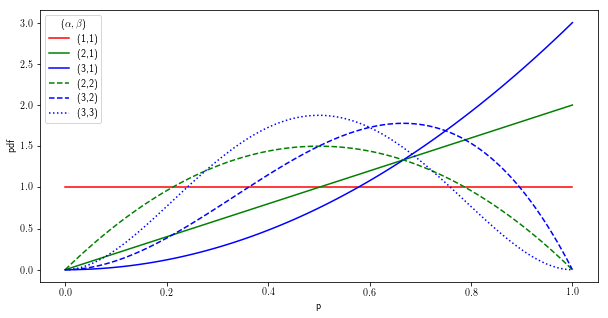

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,100)
for (a,b,s) in [(1,1,"r-"), (2,1,"g-"), (3,1,"b-"), (2,2,"g--"), (3,2,"b--"), (3,3,"b:")]:
        ax.plot(x,
                scs.beta(a,b).pdf(x),
                s,
                label="({0},{1})".format(a,b))
ax.legend(title=r"($\alpha,\beta$)", loc="upper left")
ax.set_xlabel("p")
ax.set_ylabel("pdf")

You don't see the beta distribution that often, but one situation is in the distribution of ordered quantities. If you choose $n$ random values from $U(0,1)$, the distribution of the $k^\text{th}$ smallest is given by $Beta(k, n-k+1)$. So, for example, if the you choose five random numbers, the distribution of the 1st, 2nd, 3rd, 4th, and 5th numbers are given by the graphs below.

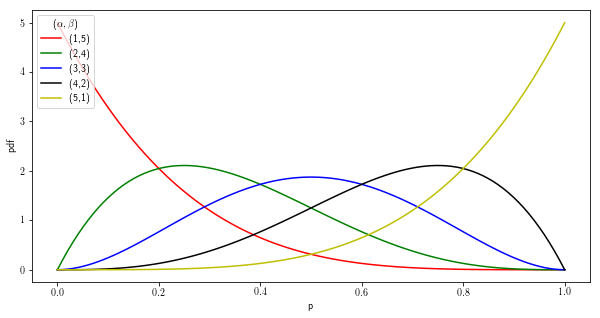

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,100)
for (a,b,s) in [(1,5,"r-"), (2,4,"g-"), (3,3,"b-"), (4,2,"k-"), (5,1,"y-")]:
        ax.plot(x,
                scs.beta(a,b).pdf(x),
                s,
                label="({0},{1})".format(a,b))
ax.legend(title=r"($\alpha,\beta$)", loc="upper left")
ax.set_xlabel("p")
ax.set_ylabel("pdf")

But we're using the beta distribution for something else.


It turns out that if the prior probabilities are given by a beta distribution, and the likelihood function is given by a Bernoulli (or binomial) distribution, then the posterior distribution will also be given by a beta distribution. In this case the formula for 

$$f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}$$

where

* $p$ is the conversion rate (**between 0 and 1**) and
* $\alpha$, $\beta$ are the shape parameters:
    * $\alpha$ = 1 + number of conversions and
    * $\beta$ = 1 + number of non-conversions.


### Conjugate Priors

The beta distribution is said to be a **conjugate prior** of the Bernoulli distribution.

$$\begin{aligned}
posterior &\propto prior * likelihood \\
beta &\propto beta * binomial \\
&= \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)} * {n \choose k} p^k (1-p)^{n-k} \\
&\propto p^{\alpha - 1}(1 - p)^{\beta - 1} * p^k (1-p)^{n-k} \\
&\propto p^{\alpha + k - 1}(1 - p)^{\beta + n - k - 1}
\end{aligned}$$

So the resulting posterior distribution is is a beta distribution with parameters $\alpha + k$ and $\beta + n - k$


A conjugate prior for a likelyhood is a class of functions such that if the prior is in the class, so is the posterior. There are [many listed in Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Likelihood                 | Prior
---------------------------|------------
Bernoulli/Binomial         | Beta distribution
Normal with known $\sigma$ | Normal distribution
Poisson                    | Gamma
Uniform                    | Pareto

How important are these to do Bayesian statistics?

## A/B testing

How do we turn this into A/B testing? Let's go back to comparing CTR for two different ads. We collect data for each ad, of how many successes and failures we get for each. Suppose it's something like:

In [62]:
success_a = 166
failure_a = 2540
success_b = 162
failure_b = 2132

Let's start with a uniform prior for the CTR for each. The happens to be a beta function, so we can use conjugate priors. Let graph the posteriors to see what they look like.

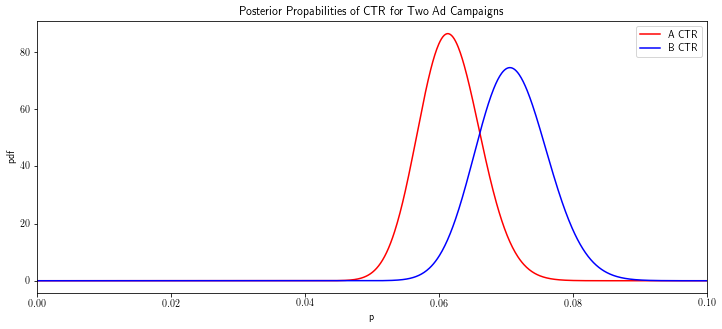

In [69]:
fig, ax = plt.subplots(figsize=(12,5))
x = np.linspace(0,1,10000)
for (a,b,s, label) in [(success_a+1, failure_a+1,"r-", "A CTR"),
                       (success_b+1, failure_b+1,"b-", "B CTR")]:
        ax.plot(x,
                scs.beta(a,b).pdf(x),
                s,
                label=label)
ax.legend(loc="upper right")
ax.set_xlabel("p")
ax.set_ylabel("pdf")
ax.set_xlim(0, 0.1)
ax.set_title("Posterior Propabilities of CTR for Two Ad Campaigns")

Suppose we want to know the probability that B is better than A. We have


In [75]:
prob_a = scs.beta(success_a+1, failure_a+1).pdf(x) / 10000
prob_b = scs.beta(success_b+1, failure_b+1).pdf(x) / 10000

Since these are independant, we can calcuate the joint probably and find the probability that the actual rate for B is great than A.

In [78]:
joint_prob = prob_a * prob_b[:, None]
(joint_prob * (x < x[:, None])).sum()

0.90541669342495457

But we could have calcuated anything. What to know the probability that B is at least 10% better than A?

In [80]:
(joint_prob * (x*1.10 < x[:, None])).sum()

0.66494732337275408

## Frequentist vs. Bayesian

In both cases, we consider an ensemble of possible randomly generated universes.

Frequentist: The hypothesis is a fixed (though unknown) reality; the observed data follows some random distribution

Bayesian: The observed data is a fixed reality; the hypotheses follow some random distribution.

## Frequentist A/B testing

Frequentist procedure

* Choose n (number of experiments/samples) based on expected size of effect.
* Run **all** experiments and observe the data.
* The significance is probability of getting result (or more extreme) assuming no effect.
* Doesn't tell you how likely it is that a is better than b.

(aside: Wald sequential analysis)

## Bayesian A/B testing

Bayesian procedure

* No need to choose n beforehand.
* Update knowledge as the experiment runs.
* Gives probability of *anything you want*.

Why doesn't everyone like this better?

# Afternoon Lecture - The Multi-Armed Bandit Problem

Morning objectives:

 * Define and explain prior, likelihood, and posterior.
 * Explain what a conjugate prior is and how it applies to A/B testing.
 * Explain the difference between Frequentist and Bayesian A/B tests.
 * Analyze an A/B test with the Bayesian approach.

Afternoon Objectives:

 * Explain how multi-armed bandit addresses the tradeoff between exploitation and exploration, and the relationship to regret.
 * Implement the multi-armed bandit algorithm.

## An example: treatments for flatulance

Suppose you're a doctor who has developed a new treatment for flatulance. You aren't sure it will actually help, so you want to compare it to a control group.

How would you do that?

What if you were a Bayesian?

The problem is that these are real people, suffering a real problem, and you help as many as possible.

In [81]:
probability = {}
probability['control'] = probabilities[0]
probability['drug'] = probabilities[1]
results = dict(control=[], drug=[], total=[])

In [82]:
def run_test(treatment):
    result = scs.bernoulli(probability[treatment]).rvs()
    results[treatment].append(result)
    results['total'].append(result)
    if result:
        print("The patient got better!")
    else:
        print("The patient is still sick :(")
    print("        got better   didn't")
    for treatment in ['control', 'drug', 'total']:
        print("{:10} {:5}  {:5}".format(treatment, results[treatment].count(1), results[treatment].count(0)))

In [99]:
run_test('control')

The patient is still sick :(
        got better   didn't
control        2      3
drug           9      3
total         11      6


In [95]:
run_test('drug')

The patient is still sick :(
        got better   didn't
control        0      1
drug           9      3
total          9      4


In [100]:
print('Probabilities of getting better:')
for treatment in ['control', 'drug']:
    print("  {:10} {:5.2f}".format(treatment, probability[treatment]))


Probabilities of getting better:
  control     0.42
  drug        0.58


With traditional A/B testing there are two phases. First we do a test to determine the best choice, known as **exploration**. Once we're done testing, we use our results; this is **exploitation**. Sometimes that's necessary if the people doing the test are different from the ones using the result, but what if they aren't? Then we can combine the two phases, starting out exploring possible results and gradually concentrating on the best choice.

## The Multi-Armed Bandit

The multi-armed bandit is a mathematical problem. Suppose we have two or more slot machines, and each slot machine (a.k.a. one-armed bandit) has a different (unknown!) chance of winning. What strategy should we follow to maximize our payoff after a finite number of plays.

In this case we're assuming the all have the same payoff ("binary bandits") but there are many version of this problem.

To understand this we talk about minimizing **regret**, the difference of what we actually won and what we would have won if we'd followed the optimal strategy (always chosen the best bandit).

How would you solve this?

## Common strategies

There are a number of common strategies that you'll implement in the assignment. Some are better than others, although a "best" strategy would require knowlege of the distribution of the payoffs.

### Greedy Algorithm

The simplest model is a "greedy" algorithm, where we always choose the bandit that's been the most successful so far. Since we want to be able to explore at least a little, we might assume that each bandit has already had a single success.

What are the limitations of this?


### Epilon-Greedy Algorithm

With epsilon-greedy we choose the best algoritm most of the time, but sometimes (with probability $\epsilon$) we choose one randomly.

Again, there isn't a "best" value, but $\epsilon = 0.1$ is typical.

What are the limitations?

### Softmax

We choose a bandit randomly in proportion to the softmax function of the payouts, e.g.

If there are three bandits, A, B, and C, the probability of choosing A is

$$ \frac{ e^{p_A/\tau} }{  e^{p_A /\tau} +  e^{p_B /\tau} + e^{p_C /\tau  } } $$

where

* $p_A$ is the average payoff of bandit A so far (assume 1.0 to start).
* $\tau$ is the "temperature" (generally constant).

How does this behave in the extremes?


* As $\tau \to \infty$, the algorithm will choose bandits equally.
* As $\tau \to 0$, it will choose the most successful so far.

What are the limitations?

### UCB1 Algorithm

Choose a bandit to maximize

$$p_A + \sqrt{\frac{2 \ln{N}}{n_A}} $$

where

 * $p_A$ is the expected payout of bandit $A$.
 * $n_A$ is the number of times bandit $A$ has played.
 * N is the total number of trials so far.

This chooses the bandit for whom the Upper Confidence Bound is the highest.

### Bayesian Bandit

Use Bayesian statistics:

* Find probability distribution of payout of each bandit thus far. (how?)
* For each bandit, sample from distribution.
* Choose bandit for whom the sample has highest expected payout.